# Recommendation as Treatments: Evaluation

In [1]:
import numpy as np
from pandas import DataFrame

from sklearn.metrics import mean_absolute_error, mean_squared_error

from plotly.graph_objs import Scatter, Histogram, Figure, Bar, Layout
from plotly.offline import iplot

## 人工データ生成

In [2]:
def sigmoid(x: float) -> float:
    return 1. / (1. + np.exp(- x))

def make_data(num_user: int, num_item: int, dim_factor: int,
              propensity_bias: float=-5., rating_bias: float=3., propensity_type="user_item") -> np.array:
    # sample user and item matrix from the prior distribution
    theta = np.random.normal(scale=.5, size=(num_user, dim_factor))
    beta = np.random.normal(scale=.5, size=(num_item, dim_factor))
    user_b = np.random.normal(scale=.5, size=(num_user, 1))
    item_b = np.random.normal(scale=.5, size=(num_item, 1))
    # generate rating and observation matrices
    user_item_value = theta @ beta.T + user_b + item_b.T
    preference = user_item_value + rating_bias
    rate = np.clip(np.round(preference), a_min=1., a_max=5.)
    # generate propensity matrix
    if propensity_type == "user_item":
        propensity = np.clip(sigmoid(user_item_value + propensity_bias), a_min=.0005, a_max=.20,)
    elif propensity_type == "rating":
        propensity = np.zeros_like(rate1)
        for i in np.arange(1, 6, 1):
            propensity[rate1 == i] = .5 * (0.01 ** (5 - i))
    elif propensity_type == "random":
        propensity = 0.05 * np.ones((num_user, num_item))
    obs = np.random.binomial(n=1, p=propensity, size=(num_user, num_item))
    return rate, propensity, obs

def preprocess_data(rate: np.array, obs: np.array, propensity: np.array) -> np.array:
    # make test data (observed data)
    p = 0.1 * (1 / (1. - propensity)) / np.max(1 / (1. - propensity))
    sample = np.random.binomial(n=1, p=p, size=propensity.shape)
    user_test, item_test = np.where((1 - obs) * sample == 1)
    rate_test = rate[user_test, item_test]
    prop_test = propensity[user_test, item_test]
    data_test = np.c_[user_test, item_test, rate_test, prop_test]
    # make training data (observed data)
    user_train, item_train = np.where(obs == 1)
    rate_train = rate[user_train, item_train]
    prop_train = propensity[user_train, item_train]
    data_train = np.c_[user_train, item_train, rate_train, prop_train]
    return data_train, data_test

## 人工データ分布

In [3]:
rate, propensity, obs = make_data(1000, 1000, 20)
data_train, data_test = preprocess_data(rate, obs, propensity)

In [4]:
data_train[:, 2].mean(), data_test[:, 2].mean()

(4.28377270864636, 3.0016093416669785)

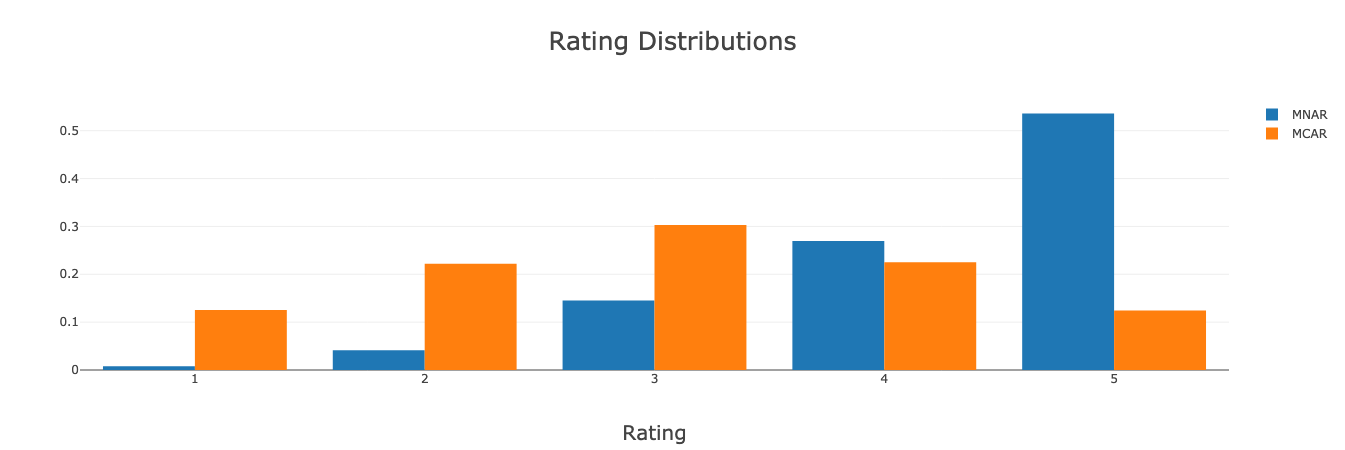

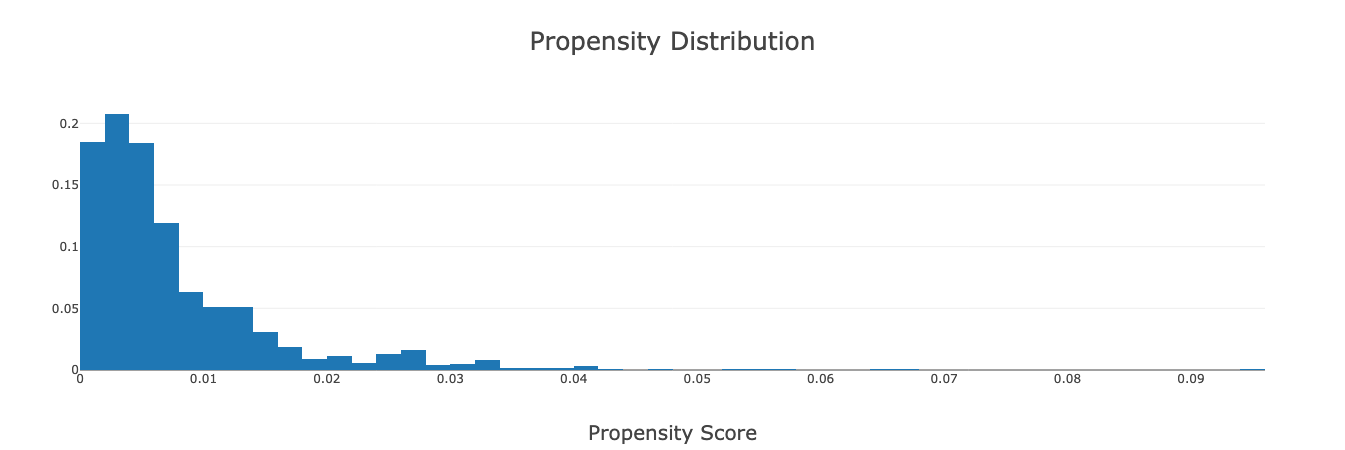

In [5]:
rate_hist_train = Histogram(x=data_train[:, 2], histnorm="probability", name="MNAR")
rate_hist_test = Histogram(x=data_test[:, 2], histnorm="probability", name="MCAR")
propensity_hist = Histogram(x=propensity[:, 0], histnorm="probability")
iplot(Figure(data=[rate_hist_train, rate_hist_test], 
             layout=Layout(title="Rating Distributions", titlefont=dict(size=25), 
                           xaxis=dict(title="Rating", titlefont=dict(size=20)))))
iplot(Figure(data=[propensity_hist],
             layout=Layout(title="Propensity Distribution", titlefont=dict(size=25),
                           xaxis=dict(title="Propensity Score", titlefont=dict(size=20)))))

## 予測値集合の生成関数

In [6]:
def rec_ones(rating: np.array) -> float:
    preds = np.copy(rating)
    fliped_rates = np.random.choice([1., 5.], 
                                    p=[0.5, 0.5], 
                                    size=np.sum(rating == 5))
    preds[preds == 5] = fliped_rates
    return preds

def rec_fours(rating: np.array) -> float:
    preds = np.copy(rating)
    fliped_rates = np.random.choice([4., 5.], 
                                    p=[0.5, 0.5], 
                                    size=np.sum(rating == 5))
    preds[preds == 5] = fliped_rates
    return preds

def skewed(rating: np.array) -> float:
    preds = np.random.normal(loc=rating, scale=(6. - rating) / 2)
    preds = np.clip(preds, a_min=0., a_max=6.)
    return preds

def rotate(rating: np.array) -> float:
    preds = np.zeros_like(rating)
    preds[rating <= 2] = rating[rating <= 2] - 1
    preds[rating == 5] = 1
    return preds

def coarsened(rating: np.array) -> float:
    preds = np.zeros_like(rating)
    preds[rating <= 3] = 3
    preds[rating > 3] = 4
    return preds

## Naive推定量とIPS推定量の比較実験

In [7]:
def run_sims(num_user: int=1000, num_item: int=1000, dim_factor: int=20,
              propensity_bias: float=-5., rating_bias: float=3.,
              n_iters: int=10) -> np.array:
    results = np.zeros((3, n_iters, 5))
    for i in np.arange(n_iters):
        np.random.seed(i)
        # generate data
        rate, propensity, obs = make_data(num_user, num_item, dim_factor, propensity_bias, rating_bias)
        data_train, data_test = preprocess_data(rate, obs, propensity)
        # make predictions
        preds_train = [f(data_train[:, 2]) for f in [rec_ones, rec_fours, rotate, skewed, coarsened]]
        preds_test = [f(data_test[:, 2]) for f in [rec_ones, rec_fours, rotate, skewed, coarsened]]
        # estimate mean squared errors
        for j, (pred_train, pred_test) in enumerate(zip(preds_train, preds_test)):
            results[0, i, j] = np.sqrt(mean_squared_error(y_true=data_test[:, 2], y_pred=pred_test))
            results[1, i, j] = np.sqrt(mean_squared_error(y_true=data_train[:, 2], y_pred=pred_train))
            results[2, i, j] = np.sqrt(mean_squared_error(y_true=data_train[:, 2], y_pred=pred_train, 
                                                          sample_weight=(1. / data_train[:, 3])))
    mean, upper, lower = np.mean(results, axis=1), np.percentile(results, q=97.5, axis=1), np.percentile(results, q=2.5, axis=1)
    return mean, upper - mean, mean - lower

In [8]:
mean, upper, lower = run_sims(n_iters=30)

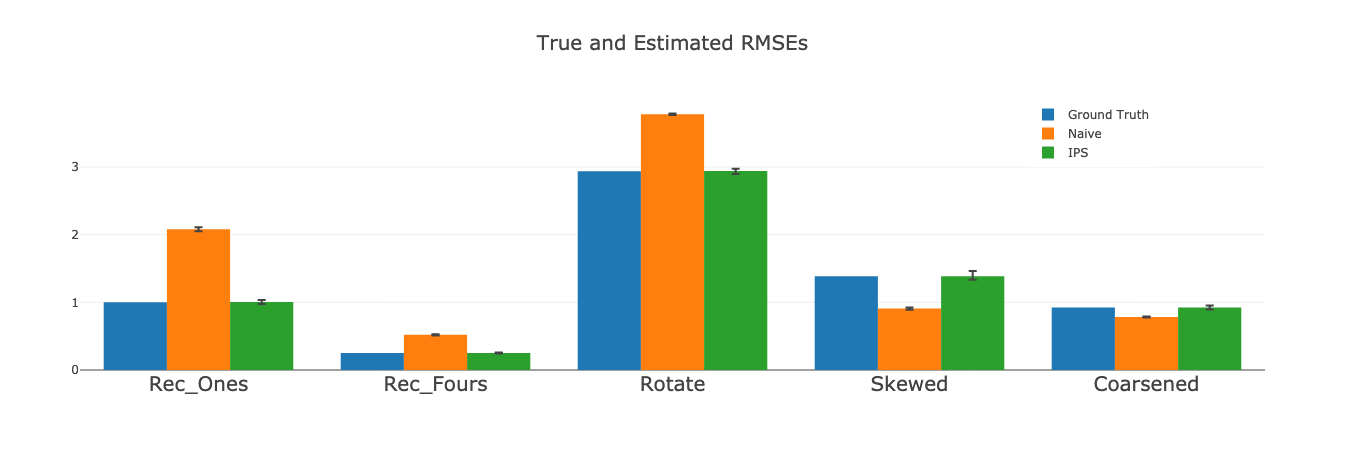

In [9]:
names = ["Rec_Ones", "Rec_Fours", "Rotate", "Skewed", "Coarsened"]
true = Bar(x=names, y=mean[0], name="Ground Truth")
naive = Bar(x=names, y=mean[1], error_y=dict(symmetric=False, array=upper[1], arrayminus=lower[1]), name="Naive")
ips = Bar(x=names, y=mean[2], error_y=dict(symmetric=False, array=upper[2], arrayminus=lower[2]), name="IPS")
layout = Layout(title="True and Estimated RMSEs", titlefont=dict(size=20), 
                xaxis=dict(tickfont=dict(size=20)),
                legend=dict(x=0.8, y=1.0),
                barmode="group")
iplot(Figure(data=[true, naive, ips], layout=layout))

In [10]:
DataFrame(mean, columns=names, index=["Ground Truth", "Naive", "IPS"])

,Rec_Ones,Rec_Fours,Rotate,Skewed,Coarsened
Ground Truth,1.000518,0.250098,2.938190,1.386851,0.924834
Naive,2.081721,0.520017,3.778322,0.907427,0.782473
IPS,1.003088,0.250869,2.940263,1.385334,0.924808


In [11]:
DataFrame(np.abs(mean[1:] - mean[0]) / mean[0], columns=names, index=["Naive", "IPS"])

,Rec_Ones,Rec_Fours,Rotate,Skewed,Coarsened
Naive,1.080643,1.079253,0.285935,0.345693,0.153932
IPS,0.002569,0.003083,0.000705,0.001094,0.000028
